# Loading The Dataset

I adapted the code for the ML assignment from the HuggingFace docs: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb

<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='../dataset')
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Marko/.cache/huggingface/datasets/imagefolder/default-3965c13e11909089/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's print out the dataset:

In [2]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 3251
})

We can also check out the features of the dataset in more detail:

In [3]:
train_ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Early Blight', 'Healthy', 'Late Blight'], id=None)}

As we can see, each example has 2 features: 'img' (of type `Image`) and 'label' (of type `ClassLabel`). Let's check an example of the training dataset:

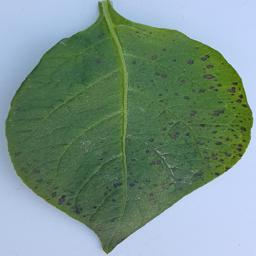

In [5]:
train_ds[1]['image']

In [5]:
train_ds[0]['label']

0

Of course, we would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [6]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Early Blight', 1: 'Healthy', 2: 'Late Blight'}

In [7]:
id2label[train_ds[0]['label']]

'Early Blight'

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`. 

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here. 

In [8]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [9]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [10]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [11]:
train_ds[:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>],
 'label': [0, 0],
 'pixel_values': [tensor([[[ 0.1529,  0.1529,  0.1529,  ...,  0.2627,  0.2627,  0.2627],
           [ 0.1529,  0.1529,  0.1529,  ...,  0.2627,  0.2627,  0.2627],
           [ 0.1529,  0.1529,  0.1529,  ...,  0.2627,  0.2627,  0.2627],
           ...,
           [ 0.2235,  0.2235,  0.2235,  ..., -0.4353, -0.4039, -0.4275],
           [ 0.2235,  0.2235,  0.2235,  ..., -0.3882, -0.3961, -0.4588],
           [ 0.2235,  0.2235,  0.2235,  ..., -0.3333, -0.3020, -0.3490]],
  
          [[ 0.4118,  0.4118,  0.4118,  ...,  0.5294,  0.5294,  0.5294],
           [ 0.4118,  0.4118,  0.4118,  ...,  0.5294,  0.5294,  0.5294],
           [ 0.4118,  0.4118,  0.4118,  ...,  0.5294,  0.5294,  0.5294],
           ...,
           [ 0.4902,  0.4902,  0.4902,  ..., -0.2392, -0.2078, -0.2314],
           [ 0.4902,  0.4902,  0.4902,  ..., -0.1608, -0

It's very easy to create a corresponding PyTorch DataLoader, like so:

In [12]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [13]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


However, we'll not be using dataloaders, as we are going to use HuggingFace's Trainer API.

## Define the model

Here we define the model. We define a `ViTForImageClassification`, which places a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) on top of a pre-trained `ViTModel`. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. 

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. You can find all info of the model we are going to use [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

We also specify the number of output neurons by setting the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as `model.config`).

In [14]:
from transformers import ViTForImageClassification
init = 'google/vit-base-patch16-224-in21k'
# import os
# resume = './test-cifar-10/checkpoint-450'
# path = resume if os.path.exists(resume) else init
# print(f"Selecting model at: {path}")
model = ViTForImageClassification.from_pretrained(init, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

We also set the argument "remove_unused_columns" to False, because otherwise the "img" column would be removed, which is required for the data transformations.

In [15]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "mlmodels/vit-potatoes-plant-health-status",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, set the training and evaluation batch_sizes and customize the number of epochs for training, as well as the weight decay.

We also define a `compute_metrics` function that will be used to compute metrics at evaluation. We use "accuracy" here.


In [16]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

Then we just need to pass all of this along with our datasets to the Trainer:

In [17]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Train the model

Let's first start up Tensorboard:

We can now finetune our model by just calling the `train` method:

In [31]:
train_results = trainer.train()

c:\Users\Marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/978 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

{'eval_loss': 0.0602007731795311, 'eval_accuracy': 0.9975961538461539, 'eval_runtime': 10.697, 'eval_samples_per_second': 38.889, 'eval_steps_per_second': 9.722, 'epoch': 1.0}
{'loss': 0.2447, 'learning_rate': 9.775051124744377e-06, 'epoch': 1.53}


  0%|          | 0/104 [00:00<?, ?it/s]

{'eval_loss': 0.038946960121393204, 'eval_accuracy': 0.9975961538461539, 'eval_runtime': 8.886, 'eval_samples_per_second': 46.815, 'eval_steps_per_second': 11.704, 'epoch': 2.0}


  0%|          | 0/104 [00:00<?, ?it/s]

{'eval_loss': 0.029214533045887947, 'eval_accuracy': 1.0, 'eval_runtime': 8.784, 'eval_samples_per_second': 47.359, 'eval_steps_per_second': 11.84, 'epoch': 3.0}
{'train_runtime': 883.3481, 'train_samples_per_second': 11.041, 'train_steps_per_second': 1.107, 'train_loss': 0.17626205397529837, 'epoch': 3.0}


TrainOutput(global_step=978, training_loss=0.17626205397529837, metrics={'train_runtime': 883.3481, 'train_samples_per_second': 11.041, 'train_steps_per_second': 1.107, 'train_loss': 0.17626205397529837, 'epoch': 3.0})

# Save The Model

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

## Evaluation

Finally, let's evaluate the model on the test set:

In [32]:
outputs = trainer.predict(test_ds)

  0%|          | 0/102 [00:00<?, ?it/s]

In [34]:
print(outputs.metrics)

{'test_loss': 0.04666883125901222, 'test_accuracy': 0.9925925925925926, 'test_runtime': 13.1849, 'test_samples_per_second': 30.717, 'test_steps_per_second': 7.736}


We can also easily create a confusion matrix:

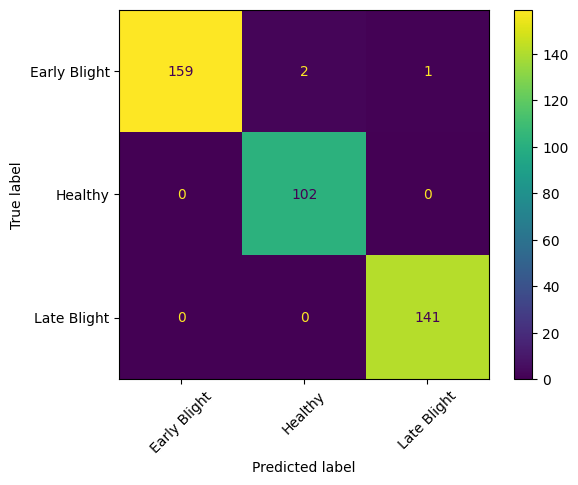

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)